# Project 6: Machine Learning on CPU vs GPU and Cloud Deployment

In this project, you will practice with using PyTorch for training ML models and Azure resources for deploying models. Your deliverables will be a set of trained models as well as a public API endpoint that anyone can send their input data to, in order to get prediction results from the models. As a reminder, the entirety of this project should be done on a `Standard_NC4as_T4_v3` GPU compute in the Azure Machine Learning Studio. You may not get the same output as the test cases if you use Google Colab or your own GPU. However, it is still useful to first run your code on an external environment to check that there are no runtime errors. If you are new to PyTorch, you will likely run into many data type or dimension errors, which you don't want to debug while an Azure GPU compute is running and draining your budget.

## Files to submit
Because this project involves computationally heavy tasks, we will only run some of your functions on the autograder. For the remaining functions, you will submit the trained model or output files for evaluation. Here is the list of all the files that the submitter executables attempt to collect in each submission:

1. **model_deployment_comparison.ipynb** (this notebook)
1. **report.md**
1. **references**
1. models/trained_LogisticRegression.pt (generated in Q9)
1. models/trained_LeNet.pt (generated in Q9)
1. models/tuned_LogisticRegression.pt **or** models/tuned_LeNet.pt **or** models/tuned_AlexNet.pt (generated in Q10)
1. score.py (generated in Q12)
1. scoring_uri.txt (generated in Q12)

The bolded files are required for every submission (although you don't need to completely fill them out until you finish the project). The remaining files are optional: the submitter scripts can make a submission without them, but in order to get full score on this project, you should have all 8 files.

## Environment setup

In [53]:
# load necessary modules
import os, time, json, copy, pickle, random, requests, re
import numpy as np
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

Make sure you see Numpy version 1.22.4 and PyTorch version 2.0.1 in the following cell; using different versions may cause you to fail the local tests.

In [55]:
print(np.__version__)
print(torch.__version__)

1.22.4
2.0.1+cu117


We first create a `device` variable which automatically uses GPU, if one is available, and CPU otherwise. This helps us switch between CPU and GPU seamlessly without needing any explicit code changes.

You should assume that all the functions from Q1 - Q11 use GPU by default, unless otherwise specified. Therefore, make sure that the output of the next cell is `device(type='cuda')`. If it is not, you should double check the compute which you are using to run this notebook.

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Next, we provide some functions to set the seed of several random generators. We will call these functions at the beginning of every test case to ensure that your code generates consistent output. You do not need to call `set_seed` in any of your implementation code.

In [57]:
GLOBAL_SEED = 1
 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

GLOBAL_WORKER_ID = None
def _init_fn(worker_id):
    global GLOBAL_WORKER_ID
    GLOBAL_WORKER_ID = worker_id
    set_seed(GLOBAL_SEED + worker_id)

set_seed(GLOBAL_SEED)

## Section A: Dataset Overview

The dataset we use here is a subset of [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), which contains 50000 32x32 RGB images belonging to 10 mutually exclusive classes (e,g., plane, car, bird). The dataset is divided into four training batches and one validation batch, each with 10000 images. Each of the batch files contains a dictionary with the following elements:

**Input data** -- a $10000 \times 3072$ matrix of type `uint8s`. Each row of the array stores a flattened 32x32 RGB image as follows:

$$\underbrace{x_1, x_2, \ldots, x_{1024}}_{\text{red channel}} \underbrace{x_{1025}, x_{1026} \ldots x_{2048}}_{\text{green channel}} \underbrace{x_{2049} x_{2050} \ldots x_{3072}}_{\text{blue channel}}$$
Each image is stored in row-major order, so that the first 32 entries of the array are the first row of the red channel values of the image.

To get more intuition about this structure, let's consider a colored $2 \times 2$ image, which can be represented as a $3 \times 2 \times 2$ matrix:
```py
image = [
    [[1, 2], [3, 4]], #red channel
    [[5, 6], [7, 8]], # blue channel
    [[9, 10], [11, 12]] # green channel
]
```
When flattening this image we get the vector
```py
v = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
```

This flattened represenation is what the data files store. So, in the context of CIFAR-10, a batch of data with $10000$ images would be a matrix with shape $$10000 \times 1024$$.

<p align="center">
    <img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png">
</p>

**Output labels** -- a list of $10000$ labels in the range $0-9$. The number at index $i$ indicates the label of the $i$-th image in the input data. We provide a mapping from the label index to the actual label in the list `classes` below.

In [58]:
train_files = ['data/train_batch_1','data/train_batch_2','data/train_batch_3','data/train_batch_4']
val_files = ['data/validation_batch']

## class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Warm-up: reconstructing a flattened image
Because the images have been flattened, our first step in reading the data is to undo this transformation. Following up on the example above, if you have the flattened vector

```py
v = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
```

and the size of the original image ($3 \times 2 \times 2$), you should be able to reconstruct the original 3D matrix:

```py
image = [
    [[1, 2], [3, 4]],
    [[5, 6], [7, 8]],
    [[9, 10], [11, 12]]
]
```

Implement the function `reconstruct_3D_images` that performs this reconstruction on a given batch of images. To ensure efficiency, you should not loop through individual images in the batch; instead, identify a NumPy method to reconstruct the entire batch at once.

In [59]:
def reconstruct_3D_images(flatted_images, depth, width, height):
    """
    Reconstruct a batch of 3D images given their flattened vector and the original image dimensions
    
    args:
        flatted_images (np.ndarray) : a batch of images, each flattened from 3D to 1D
        width (int) : the width of the original 3D image
        height (int) : the height of the original 3D image
        depth (int) : the depth of the original 3D image
    
    returns:
        np.ndarray : a 4D matrix of shape (N, depth, height, width)
            where N is the batch size
    """

    N = len(flatted_images)
    return flatted_images.reshape(N, depth, height, width )

We test this function on the synthetic example above and on an actual image.

All tests passed
You should see a blurry image of a ship


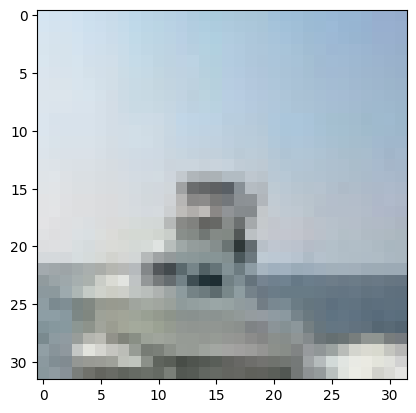

In [60]:
def test_reconstruct_3D_images():
    img1 = [
        [[0, 1], [2, 3], [4, 5], [6, 7]],
        [[8, 9], [10, 11], [12, 13], [14, 15]],
        [[16, 17], [18, 19], [20, 21], [22, 23]]
    ]
    img2 = [
        [[24, 25], [26, 27], [28, 29], [30, 31]],
        [[32, 33], [34, 35], [36, 37], [38, 39]],
        [[40, 41], [42, 43], [44, 45], [46, 47]]
    ]
    flattened_images = np.array([np.arange(24), np.arange(24, 48)])
    reconstructed_images = reconstruct_3D_images(flattened_images, 3, 2, 4)
    assert reconstructed_images.tolist() == [img1, img2]
    
    img1 = img2 = np.load('ship_original.npy').tolist()
    flattened_images = np.array([np.loadtxt('ship_flattened.txt'), np.loadtxt('ship_flattened.txt')])
    reconstructed_images = reconstruct_3D_images(flattened_images, 3, 32, 32)
    assert reconstructed_images.tolist() == [img1, img2]
    print("All tests passed")
    
    plt.imshow(np.transpose(reconstructed_images[0].astype(int), (1, 2, 0)))
    print("You should see a blurry image of a ship")
    
test_reconstruct_3D_images()

### Question 1: Preparing data for PyTorch


PyTorch has an abstract class called [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) which we can subset to specify our own data preprocessing pipeline. Implement the methods `__init__()`, `__len__()`, and `__getitem__()` in the `ImageDataset` class so that:

* `__init__` reads all the data from a given list of filenames and creates two instance variables, `self.data` and `self.labels`. 
    * `self.data` is a container for the dataset, which is constructed by:
        1. Reading the data file of flattened images in the input filename list.
        1. Reconstructing the 3D representations of all flattened images.
        1. Performing an appropriate transpose to obtain the final shape `(n_images, height, width, n_channels)`.

    * `self.labels` is a 1D Python list of image labels.

* `__len()__` should return the number of images in the dataset. We have implemented this function for you.

* `__getitem()__` takes as input an index `idx` and returns the data point at index `idx`, which is a tuple of `(image, label)`, where `image` is a normalized tensor and `label` is a label index from 0-9.
    * To transform an image from NumPy matrix format to normalized tensor format, you should make use of the instance variable `self.transform` provided in the `__init__` function. Check the [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) for example usage.

**Notes:**
* Each CIFAR data file can be opened with the `pickle` module, using the `latin1` encoding. The extracted file will be a dictionary, `d`. `d["data"]` is a NumPy array of flattened images with shape `(n_images, 3072)`, while `d["labels"]` is a Python list of `n_images` labels.
* If the Sail() autograder says that your code produces empty output with no error message, you are using too much memory. Make sure to close any file you open, and keep in mind that NumPy methods that return a new array in memory (such as `np.concatenate` and `np.stack`) should not be used inside a loop.

In [61]:
class ImageDataset(Dataset):

    def __init__(self, data_files):
        """
        Initializes self.data as a container for the dataset and self.labels as a container for the labels.

        args: 
             data_files (List[str]): list of data filenames to read from
        """
        # do not modify this code
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        data_list = []
        labels_list = []
        
        for file in data_files:
            with open(file, 'rb') as fo:
                d = pickle.load(fo, encoding = 'latin1')
                flattened_image = d["data"]
                image_3D = reconstruct_3D_images(flattened_image, 3,32,32)
                transposed_image = image_3D.transpose(0,2,3,1)
                data_list.append(transposed_image)
                
                labels = d["labels"]
                labels_list.extend(labels)
        
        self.data = np.concatenate(data_list, axis=0)  
        self.labels = np.array(labels_list)

        
     
    def __len__(self):
        """
        Get the dataset length.

        return:
            int : the number of images in the dataset
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Fetch and transform the data sample at the given index.

        args:
            idx (int): index to get an image data

        return:
            Tuple(img, label):
                img (torch.Tensor) : a normalized tensor of size (n_channels, height, width)
                label (int) : the label of img
        """
        img = self.data[idx]
        img = self.transform(img)
        label = self.labels[idx]
        
        return img, label

In [62]:
def dataset_test():
    trainset = ImageDataset(train_files)
    valset = ImageDataset(val_files)
    assert trainset.data.dtype == np.uint8
    assert trainset.data.shape == (40000, 32, 32, 3)
    assert set(trainset.labels) == set(range(10))
    assert (trainset.labels[:5] == np.array([6, 9, 9, 4, 1])).all()
    assert trainset.data.shape == (40000, 32, 32, 3)
    assert valset.data.shape == (10000, 32, 32, 3)
    assert len(trainset) == 40000
    assert len(valset) == 10000

    # get training image at index 2
    assert trainset[2][0][0][:3][:,:3].equal(torch.tensor([
        [1.0, 0.9843137264251709,0.9843137264251709 ],
        [1.0, 1.0,1.0],
        [1.0, 0.9921568632125854, 0.9921568632125854]
    ]))
    # get training label at index 2
    assert trainset[2][1] == 9

    # get validation image at index 2
    assert valset[2][0][0][:3][:,:3].equal(torch.tensor([
        [-0.09019607305526733, -0.498039186000824, -0.8509804010391235],
        [-0.10588234663009644, -0.498039186000824, -0.8588235378265381],
        [-0.10588234663009644, -0.5137255191802979, -0.8666666746139526]
    ]))
    # get validation label at index 2
    assert valset[2][1] == 5
    print('All tests passed!')

dataset_test()

All tests passed!


### Question 2: Create Dataloader

Now that we have the training and validation set, the next step is to split them into minibatches, so that we can iterate over each minibatch in our training. PyTorch has a [DataLoader class](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to support this process. Implement the function `get_dataloader` that uses DataLoader to create iterables over the training and validation set with the given batch size.

**Notes**:
* When creating a DataLoader instance, the `shuffle` option should be `True` for the training set and `False` for the validation set.
* You should also set `worker_init_fn` to `_init_fn` (recall that we have provided the `_init_fn` implementation for you in the code cell above Part A) and `num_workers` to the provided `num_workers` parameter.

In [63]:
def get_dataloader(trainset, valset = None, batch_size = 64, num_workers = 2):
    """
    Create iterators over the minibatches of the training and validation data.
    
    arg:
        trainset (ImageDataset): instance of ImageDataset with training data
    
    kwargs:
        valset (ImageDataset): instance of ImageDataset with validation data, can be None
        batch_size (int): number of images per minibatch
        num_workers (int): the number of subprocesses used for data loading

    return: 
        Tuple(train_loader, val_loader):
            train_loader (DataLoader): iterable for trainset minibatches
            val_loader (DataLoader): iterable for valset minibatches, or None if valset is None
    """
 
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers,worker_init_fn=_init_fn)
    if valset is None:
        val_loader = None
    else:
        val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers,worker_init_fn=_init_fn)
        
    return (train_loader,val_loader)
        

In [64]:
def dataloader_test():
    set_seed(GLOBAL_SEED)
    trainset = ImageDataset(train_files)
    valset = ImageDataset(val_files)
    train_loader, val_loader = get_dataloader(trainset, valset)
    
    assert train_loader.dataset == trainset
    assert train_loader.batch_size == 64

    train_images, train_labels = next(iter(train_loader))
    assert train_labels[:5].equal(torch.tensor([7, 3, 3, 4, 2]))

    val_images, val_labels = next(iter(val_loader))
    assert val_labels[4:9].equal(torch.tensor([5, 7, 4, 3, 8]))
    print('All tests passed!')

dataloader_test()

All tests passed!


## Section B: Model Implementation
In this part, we will implement three classifier models using PyTorch, which include a logistic regression model and two convolutional network architectures, LeNet and AlexNet.

To begin, we provide a function that counts the number of parameters in a given model. We will use this to get a better idea of how many parameters are typically required for this kind of image classification task.  



In [65]:
# do not modify this function
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Question 3: Logistic regression
Recall from the primer that we can treat a logistic regression model as a neural network with a single linear layer (and softmax activation function). Implement the class `LogisticRegression` with this structure.

**Notes**:
* If the input data to `forward` is a multi-dimensional tensor, it needs to be flattened before being passed to the linear layer.
* The softmax activation function is not a part of the `LogisticRegression` class itself, since it is covered in the cross entropy loss which we will use later in training. Therefore, `LogisticRegression` will only have a linear layer.

In [66]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the network layers.

        args:
            input_dim (Tuple): the shape (n_channels, height, width) of a sample data point
            output_dim (int): the number of nodes in the output layer
        """
        super(LogisticRegression, self).__init__()
        input_features = input_dim[0] * input_dim[1] *  input_dim[2]
        self.layers = nn.Linear(input_features, output_dim)
        
    def forward(self, x):
        """
        Get the output of the forward pass

        args:
            x (array-like): a batch of input data

        return:
            tensor[float]: a tensor with output_dim elements, output from the forward pass of this network
        """
        x = x.reshape(x.size(0), -1)
        out = self.layers(x)
        return out

In [67]:
def test_logistic_regression():
    set_seed(GLOBAL_SEED)
    data = (torch.rand(1, 3, 32, 32) * 255)
    lr_model = LogisticRegression((3, 32, 32), 10)
    output = lr_model(data).detach().numpy()
    expected_output = np.array([[
        103.10795,   -114.899765,     9.040313,   173.60179,     58.90976,
        -99.95934,     10.475531,    25.296503,   -12.6308775,   40.47077
    ]])
    
    assert count_parameters(lr_model) == 30730
    assert output.shape == expected_output.shape
    assert np.allclose(output, expected_output)
    print("All tests passed!")
    
test_logistic_regression()

All tests passed!


### Question 4: LeNet
We now implement a variation of a classic CNN architecture called [LeNet](http://yann.lecun.com/exdb/lenet/), which consists of the following layers:

1. Input layer.
1. Convolutional layer with $K = 6, F = 5, S = 1, P = 0$.
1. ReLU layer.
1. Maxpool layer with $F = S = 2$.
1. Convolutional layer with $K = 16,  F = 5, S = 1, P = 0$.
1. ReLU layer.
1. Maxpool layer with $F = S = 2$.
1. Linear layer with 120 ouput nodes.
1. ReLU layer.
1. Linear layer with 84 output nodes.
1. ReLU layer.
1. Linear layer with `output_dim` output nodes.

Implement the class `LeNet` based on the outline above.

**Notes**:
* Refer to the dimension computations in Section 2.4.2 of the [Deep Learning and Computer Vision primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/dl-cv-primer/dl_cv_primer.ipynb) to see how to determine the output dimension of a layer based on its input dimension and hyperparameters.

In [68]:
class LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the network layers.

        args:
            input_dim (Tuple): the shape (n_channels, height, width) of a sample data point
            output_dim (int): the number of nodes in the output layer
        """
        super(LeNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(5*5*16,120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_dim)
        )

    def forward(self, x):
        """
        Get the output of the forward pass

        args:
            x (array-like): a batch of input data

        return:
            tensor[float]: a tensor with output_dim elements, output from the forward pass of this network
        """
        return self.layers(x)

In [69]:
def test_lenet():
    set_seed(GLOBAL_SEED)
    data = (torch.rand(1, 3, 32, 32) * 255)
    lenet = LeNet((3, 32, 32), 10)
    expected_output = np.array([[
        -4.061032772064209, 1.5774850845336914, 2.344625949859619, -2.4299728870391846, 3.5291049480438232,
        0.5699751377105713, -2.208556652069092, 4.889535903930664, 2.7112417221069336, -1.9356430768966675
    ]])
    output = lenet(data).detach().numpy()

    assert count_parameters(lenet) == 62006
    assert output.shape == expected_output.shape
    assert np.allclose(output, expected_output)
    print("All tests passed!")
    
test_lenet()

All tests passed!


### Question 5: AlexNet
Our third model is a variation of another CNN architecture called [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), which consists of the following layers:

1. Input layer
1. Convolutional layer, $K = 64, F = 3, S = 2, P = 1$.
1. ReLU layer
1. Maxpool layer, $F = S = 2$.
1. Convolutional layer, $K = 192, F = 3, S = 1, P = 1$.
1. ReLU layer
1. Maxpool layer, $F = S = 2$
1. Convolutional layer, $K = 384, F = 3, S = 1, P = 1$
1. ReLU layer
1. Convolutional layer, $K = 256, F = 3, S = 1, P = 1$
1. ReLU layer
1. Convolutional layer, $K = 256, F = 3, S = 1, P = 1$
1. ReLU layer
1. Maxpool layer, $F = S = 2$
1. Dropout layer
1. Linear layer with 4096 output nodes
1. ReLU layer
1. Dropout layer
1. Linear layer with 1024 output nodes
1. ReLU layer
1. Linear layer with `output_dim` output nodes

**Notes**:
* Note the use of a dropout layer, which randomly zeroes some of the elements of the input tensor with probability $p = 0.5$ during training, in order to prevent overfitting. This is supported by `torch.nn.Dropout`.
* To save memory, you can set `inplace = True` in the ReLU layers (but don't specify this parameter in the Dropout layers).

In [70]:
class AlexNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the network layers.

        args:
            input_dim (Tuple): the shape (n_channels, n_height, n_width) of a sample data point
            output_dim (int): the number of nodes in the output layer
        """
        super(AlexNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), #2
            nn.ReLU(inplace=True), #3
            nn.MaxPool2d(kernel_size=2, stride=2), #4
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1), #5
            nn.ReLU(inplace=True), #6
            nn.MaxPool2d(kernel_size=2, stride=2), #7
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1), #8
            nn.ReLU(inplace=True), #9
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), #10
            nn.ReLU(inplace=True), #11
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #12
            nn.ReLU(inplace=True), #13
            nn.MaxPool2d(kernel_size=2, stride=2), #14
            nn.Dropout(), #15
            nn.Flatten(), 
            nn.Linear(2*2*256,4096), #16
            nn.ReLU(inplace=True), #17
            nn.Dropout(), #18 
            nn.Linear(4096,1024), #19
            nn.ReLU(inplace=True), #20
            nn.Linear(1024, output_dim) #21
        )

    def forward(self, x):
        """
        Get the output of the forward pass

        args:
            x (array-like): a batch of input data

        return:
            tensor[float]: a tensor with output_dim elements, output from the forward pass of this network
        """
        return self.layers(x)

In [71]:
def test_alexnet():
    set_seed(GLOBAL_SEED)
    data = (torch.rand(1, 3, 32, 32) * 255)
    alexnet = AlexNet((3, 32, 32), 10)
    expected_output = np.array([[
        0.2438529,  -0.43062437, -0.39223233,  0.0713978, 1.065471,
        -1.2516553, 0.5429566, -0.12359135, -1.2486352, 0.21474946
    ]])
    output = alexnet(data).detach().numpy()

    assert output.shape == expected_output.shape
    assert count_parameters(alexnet) == 10655562
    assert np.allclose(output, expected_output), output
    print("All tests passed!")
    
test_alexnet()

All tests passed!


We see that there is quite a discrepancy between these three models' parameter counts: logistic regression has close to 30 thousands; LeNet has close to 60 thousands, while AlexNet has more than 10 million parameters. Let's see if the additional parameters also correspond to improved performance in our task.

## Section C: Training Preparation

We now initialize the components for model training as global variables. First we will create the training and validation sets as instances of `ImageDataset`. Second, as this is a multi-class classification problem, we will use cross entropy as our loss function.

In [72]:
set_seed(GLOBAL_SEED)
full_trainset, full_valset = ImageDataset(train_files), ImageDataset(val_files)
input_dim, output_dim = (3, 32, 32), 10
criterion = nn.CrossEntropyLoss()

### Question 6: Train model for one epoch

We define a helper function to perform model training in one epoch, i.e., going through all minibatches once. Implement the function `train_one_epoch` which loops over all the minibatches in a given `DataLoader` to train a model and records the average training loss, the training accuracy, as well as training time.

**Note:**
* Before looping through the minibatches, make sure to call `model.train()` to set your model to training mode. While this mode is enabled by default, later on we will alternate between training and validation, so it is good practice to be explicit about the model's mode every time.
* Remember to move all the input data and label to `device` as you loop through `train_loader`. To move a tensor `x` to `device`, you can run `x = x.to(device)` (note the reassignment is necessary here).
* The average training loss is defined as the sum of loss values across all minibatches, divided by the number of minibatches.
* After training in each minibatch, you can compute the number of correctly classified images in that minibatch (recall from Project 4 that the predicted label of a data point corresponds to the highest hypothesis value). The training accuracy is defined as the number of correctly classified images across the entire dataset, divided by the dataset size.
* You should record the start time at the start of the function (with `time.time()`) and end time before the return statement. The difference between these time points is considered the training time.
* If your code passes the logistic regression test case but failes the AlexNet test case in the local test on Azure, the issue may be in your AlexNet implemention; make sure to follow the Q5 specifications closely.

In [73]:
def train_one_epoch(model, train_loader, optimizer):
    
    """
    Train a given model on all minibatches provided by a dataloader 
    
    args:
        model (nn.Module): an instance of a model class (LogisticRegression, LeNet or AlexNet)
        train_loader (DataLoader): iterable for trainset minibatches
        optimizer (optim.Optimizer): an instance of an optimizer class in torch.optim
    
    return: Tuple(avg_train_loss, train_accuracy, train_time)
        avg_train_loss (float): average training loss across batches
        train_accuracy (float): portion of correctly classified images in the training dataset
        train_time (float): the time taken to run this function
    """
    total_loss = 0
    total_size = 0
    total_correct_images = 0
    
    start_time = time.time()
    model.train()
    
    for inputs,labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        Y_hat = model(inputs)
        loss = criterion(Y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(Y_hat.data, 1)  
        total_size += labels.size(0)
        total_correct_images += (predicted == labels).sum().item() 
        
    avg_loss = total_loss / len(train_loader)
    training_accuracy = total_correct_images / total_size
    
    end_time = time.time()
    train_time = end_time - start_time
    
    return (avg_loss, training_accuracy, train_time)
        
    
    

In [74]:
def test_train_one_epoch():
    set_seed(GLOBAL_SEED)
    # training logistic regression model
    lr_model = LogisticRegression(input_dim, output_dim)
    lr_model.to(device)

    optimizer = optim.Adam(lr_model.parameters(), lr=0.001, weight_decay = 5e-4)
    trainset = ImageDataset([train_files[0]])
    train_loader, _ = get_dataloader(trainset)
    avg_train_loss, train_accuracy, train_time = train_one_epoch(lr_model, train_loader, optimizer)

    assert np.allclose(avg_train_loss, 1.9157349903872058), avg_train_loss
    assert train_accuracy == 0.3331, train_accuracy
    
    set_seed(GLOBAL_SEED)
    # training AlexNet model
    alexnet = AlexNet(input_dim, output_dim)
    alexnet.to(device)
    optimizer = optim.Adam(alexnet.parameters(), lr=0.001, weight_decay = 5e-4)
    train_loader, _ = get_dataloader(trainset)
    avg_train_loss, train_accuracy, train_time = train_one_epoch(alexnet, train_loader, optimizer)
    assert np.allclose(avg_train_loss,  1.9889057122977676), avg_train_loss
    assert train_accuracy == 0.22, train_accuracy
    print('All tests passed!')

test_train_one_epoch()

All tests passed!


### Question 7: Validate the trained model

After training a model, we need to evaluate its generalizability with the validation data. Given a trained model and validation dataloader, implement the function `validate_model()` that uses the trained model to predict the validation labels, returning the validation loss, accuracy and running time.

**Note:**

* Similar to `train_one_epoch`, you should record the start time at the begining and end time before returning, then calculate their difference as the validation time.
* Before looping through the minibatches, make sure to call `model.eval()` to set your model to evaluation mode, and also call `with torch.no_grad()` to disable gradient computation (note the `with` is necessary here, see the PyTorch primer on how to use this call).
* Remember to move all the input data and label to `device` as you loop through `val_loader`. To move a tensor `x` to `device`, you can run `x = x.to(device)`.
* If your code passes the logistic regression test case but failes the AlexNet test case in the local test on Azure, the issue may be in your AlexNet implemention; make sure to follow the Q5 specifications closely.

In [75]:
def validate_model(model, val_loader):  
    """
    Validate a given model with a validation dataloader.
    
    args:
        model (nn.Module): the trained model 
        val_loader (DataLoader): iterable for valset minibatches

    return: Tuple(avg_val_loss, val_accuracy, val_time)
        avg_val_loss (float): average validation loss across batches
        val_accuracy (float): portion of correctly classified images in the validation dataset
        val_time (float): the time taken to run this function
    """
    
    total_loss = 0
    total_size = 0
    total_correct_images = 0
    
    start_time = time.time()
    model.eval()
    
    with torch.no_grad():
        for inputs,labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            Y_hat = model(inputs)
            loss = criterion(Y_hat, labels)

            total_loss += loss.item()

            _, predicted = torch.max(Y_hat.data, 1)  
            total_size += labels.size(0)
            total_correct_images += (predicted == labels).sum().item() 
        
    avg_loss = total_loss / len(val_loader)
    val_accuracy = total_correct_images / total_size
    
    end_time = time.time()
    val_time = end_time - start_time
    
    return (avg_loss, val_accuracy, val_time)

In [76]:
def test_validate_model():
    set_seed(GLOBAL_SEED)
    # validate logistic regression model
    lr_model = LogisticRegression(input_dim, output_dim)
    lr_model.to(device)

    optimizer = optim.Adam(lr_model.parameters(), lr=0.001, weight_decay = 5e-4)
    trainset = ImageDataset([train_files[0]])
    valset = ImageDataset([val_files[0]])
    train_loader, val_loader = get_dataloader(trainset, valset)
    train_one_epoch(lr_model, train_loader, optimizer)

    avg_val_loss, val_accuracy, val_time = validate_model(lr_model, val_loader)
    assert np.allclose(avg_val_loss, 1.8939218923544427), avg_val_loss
    assert val_accuracy == 0.3491, val_accuracy
    
    # validate AlexNet model
    set_seed(GLOBAL_SEED)
    alexnet = AlexNet(input_dim, output_dim)
    alexnet.to(device)
    optimizer = optim.Adam(alexnet.parameters(), lr=0.001, weight_decay = 5e-4)
    train_loader, val_loader = get_dataloader(trainset, valset)
    train_one_epoch(alexnet, train_loader, optimizer)
    avg_val_loss, val_accuracy, val_time = validate_model(alexnet, val_loader)
    assert np.allclose(avg_val_loss, 1.9927906162419897), avg_val_loss
    assert val_accuracy == 0.2727, val_accuracy
    
    print('All tests passed!')

test_validate_model()

All tests passed!


### Question 8: Train model for mutiple epochs

We usually train a model for multiple epochs to get better results. Implement the `train_model` function that trains a given model for `n_epochs` times, evaluates its performance at each epoch, and returns the best state of the model (i.e., the state at the epoch when the best validation accuracy is yielded).

**Notes**:
* If two model states at two different epoch numbers yield the same best validation accuracy, pick the state corresponding to the *lower* epoch number. Also note that the epoch numbers should be indexed from 1, not 0 (i.e., the first epoch is called epoch 1).
* To save a model state, you can make a **deep copy** of its `state_dict()`, using the `copy` module imported at the start of this notebook. To load a model state, you can call `.load_state_dict()` on an instance of the same model class.
* Note the difference between `model.load_state_dict()` and `model = model.load_state_dict()`; the latter is **incorrect**.
* This function has a `scheduler` parameter, which is used to dynamically adjust the learning rate during training. You can see its use case in the [official documentation](https://pytorch.org/docs/stable/optim.html). In summary, if `scheduler` is not `None`, `scheduler.step()` should be called once every epoch *after* all the training iterations in that epoch have finished. In later questions, you will get to specify your own `scheduler`.
* We also provide a `verbose` flag. If you would like to add print debugging messages during model training, put every print statement under an `if verbose` check, for example

```python
if verbose:
    print("Training accuracy is", train_acc)
    print("Validation accuracy is", val_acc)
```
During your work you can set `verbose = True` to help with debugging; our autograder will only call `train_model` with `verbose = False`, so that your printout messages do not interfere with the grading.

* You can record the total time by summing over all the time values returned by `train_one_epoch` and `validate_models`.

In [77]:
def train_model(model, n_epochs, train_loader, val_loader, optimizer, scheduler = None, verbose = False):
    """
    Train the model for several epochs, recording the best model state and training / validation time and performance
    
    args:
        model (nn.Module): an instance of a model class (LogisticRegression, LeNet or AlexNet)
        n_epochs (int): the number of epochs to train for
        train_loader (DataLoader): iterable for trainset minibatches
        val_loader (DataLoader): iterable for valset minibatches
        optimizer (optim.Optimizer): an instance of an optimizer class in torch.optim

    kwargs:
        scheduler (optim.lr_scheduler): a PyTorch scheduler that can adjust the learning rates during training
        verbose (bool): a flag that indicates whether print statements should be executed

    return:
        Tuple(best_acc_model, best_acc_epoch_num, train_acc, train_losses, val_acc, total_time)
            best_acc_model (nn.Module): the model with the weight parameters that yield the best validation accuracy across all epochs
            best_acc_epoch_num (int): the epoch number where the best validation accuracy occurs (indexed from 1)
            train_accs (List[float]): list of average training accuracy in each epoch
            train_losses (List[float]): list of average training loss in each epoch
            val_accs (List[float]): list of validation accuracy in each epoch
            total_time (float): the sum of train time and validation time across all epochs
    """
    train_accs = []
    train_losses = []
    val_accs = []
    best_accuracy = 0
    best_epoch_num = 0
    best_model_state = None
    total_time = 0
    
    for epoch in range(n_epochs):
        train_avg_loss, train_accuracy, train_time = train_one_epoch(model, train_loader, optimizer)
        val_avg_loss, val_accuracy, val_time = validate_model(model, val_loader) 
        
        train_accs.append(train_accuracy)
        train_losses.append(train_avg_loss)
        val_accs.append(val_accuracy)
        
        if best_accuracy < val_accuracy:
            best_accuracy = val_accuracy 
            best_epoch_num = epoch + 1
            best_model_state = copy.deepcopy(model.state_dict())
        elif best_accuracy == val_accuracy :
                if epoch < best_epoch_num-1:
                    best_epoch_num = epoch + 1
                    best_model_state = copy.deepcopy(model.state_dict())
    
        
        if scheduler is not None:
            scheduler.step()
            
        if verbose:
            print("Epoch: ",epoch)
            print("Training accuracy is", train_accuracy)
            print("Validation accuracy is", val_accuracy)
        
        total_time += (train_time + val_time)
        
        
    model.load_state_dict(best_model_state)
    return (model, best_epoch_num, train_accs, train_losses, val_accs, total_time)
        
        

In [78]:
def test_train_model():
    set_seed(GLOBAL_SEED)
    model = AlexNet(input_dim, output_dim)
    model.to(device)

    trainset = ImageDataset([train_files[0]])
    valset = ImageDataset([val_files[0]])
    train_loader, val_loader = get_dataloader(trainset, valset)

    # no scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    best_model, best_acc_epoch_num, train_accs, train_losses, val_accs, total_time = \
        train_model(model, 5, train_loader, val_loader, optimizer, scheduler=None, verbose = True)

    assert not isinstance(best_model, torch.nn.modules.module._IncompatibleKeys), "Make sure you do not assign model to be model.load_state_dict()."
    assert best_acc_epoch_num == 5
    assert train_accs == [0.22, 0.3352, 0.4103, 0.4582, 0.4977], train_accs
    assert np.allclose(train_losses, [1.9889057122977676, 1.705672437977639, 1.5514380180152358, 1.4573275154563272, 1.363847457679214]), train_losses
    # print(val_accs)
    assert val_accs == [0.2727, 0.3604, 0.4106, 0.4442, 0.4689], val_accs

    # with scheduler
    set_seed(GLOBAL_SEED)
    model = AlexNet(input_dim, output_dim)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 * epoch)
    best_model, best_acc_epoch_num, train_accs, train_losses, val_accs, total_time = \
        train_model(model, 5, train_loader, val_loader, optimizer, scheduler=scheduler, verbose = True)

    assert not isinstance(best_model, torch.nn.modules.module._IncompatibleKeys), "Make sure you do not assign model to be model.load_state_dict()."
    assert best_acc_epoch_num == 5, best_acc_epoch_num
    assert train_accs == [0.098, 0.1804, 0.2667, 0.3117, 0.3212], train_accs
    assert np.allclose(train_losses, [2.3026453917193566, 2.0861207482161794, 1.8549790860741002, 1.7612957673467649, 1.7447437754102573]), train_losses
    assert val_accs == [0.0957, 0.2325, 0.3061, 0.299, 0.3472], val_accs
    print('All tests passed!')

test_train_model()

Epoch:  0
Training accuracy is 0.22
Validation accuracy is 0.2727
Epoch:  1
Training accuracy is 0.3352
Validation accuracy is 0.3604
Epoch:  2
Training accuracy is 0.4103
Validation accuracy is 0.4106
Epoch:  3
Training accuracy is 0.4582
Validation accuracy is 0.4442
Epoch:  4
Training accuracy is 0.4977
Validation accuracy is 0.4689
Epoch:  0
Training accuracy is 0.098
Validation accuracy is 0.0957
Epoch:  1
Training accuracy is 0.1804
Validation accuracy is 0.2325
Epoch:  2
Training accuracy is 0.2667
Validation accuracy is 0.3061
Epoch:  3
Training accuracy is 0.3117
Validation accuracy is 0.299
Epoch:  4
Training accuracy is 0.3212
Validation accuracy is 0.3472
All tests passed!


## Section D: Model Training and Fine-tuning
In this part, we will use more computational resources to train our models properly and get better accuracy. You will also get to explore the hyperparameter options to produce a trained model that meets a given performance requirement.

### Question 9: Train and save model to file
Implement the function `train_and_save_model` which, given a set of hyperparameters, trains the model on all of the $40000$ training data images and saves the trained model to a file in the `models` directory. The function takes as input a model instance of class `LogisticRegression`, `LeNet` or `AlexNet`. It also takes as input an optional parameter `filepath`, which specifies the path of the file that contains the saved model; if this parameter is not provided, the default path should be `"models/trained_{classname}.pt"`, for example `"models/trained_AlexNet.pt"`.

**Notes**:
* You will run this function on  both GPU and CPU and record the outcomes in each case. Therefore, remember to call `model.to(device)` at the beginning of the function.
* Recall that we already initialized `full_trainset` and `full_valset` as global instances of `ImageDataset` earlier. Therefore, you only need to create the DataLoader iterables based on the given `batch_size` in this function.
* When saving a model to a file, you only need to save its `state_dict()`, not the entire model. See the [official guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) here for more details. 
* To get the class name of an instance variable `v`, you can call `v.__class__.__name__`.
* If you see the following error message:
```
AttributeError: '_IncompatibleKeys' object has no attribute ...
```
you are returning the return value of `model.load_state_dict()` somewhere in an earlier question. Keep in mind that after calling `model.load_state_dict()`, you need to return the `model` itself.

In [79]:
def train_and_save_model(model, optimizer, batch_size=64, n_epochs=5, scheduler=None, filepath=None, verbose=False):
    """
    Train a model based on the given model name, batch size, epoch number, optimizer and scheduler.
    Then save the trained model's state_dict to a file. 
    
    args:
        model (nn.Module): an instance of a model class (LogisticRegression, LeNet or AlexNet)
        optimizer (optim.Optimizer): an instance of an optimizer class in torch.optim
    
    kwargs:
        batch_size (int): the minibatch size for DataLoader
        n_epochs (int): the number of epochs to train for
        scheduler (optim.lr_scheduler): a PyTorch scheduler that can adjust the learning rates during training
        filepath (str): the path of the file to save the trained model to
        verbose (bool): a flag that indicates whether print statements should be executed

    return: Tuple(best_acc_model, best_acc_epoch_num, train_accs, val_accs, total_time)
        best_acc_model (nn.Module): the model with the weight parameters that yield the best validation accuracy across all epochs
        best_acc_epoch_num (int): the epoch number where the best validation accuracy occurs (indexed from 1)
        train_accs (List[float]): list of average training accuracy in each epoch
        val_accs (List[float]): list of validation accuracy in each epoch 
        total_time (float): the sum of train time and validation time across all epochs, returned from train_model
    """
    model.to(device)
    
    train_loader, val_loader = get_dataloader(full_trainset, full_valset, batch_size, num_workers = 2)
    #val_loader = get_dataloader(full_trainset, full_valset, batch_size, num_workers = 2)
    
    
    best_model, best_epoch_num, train_accs, train_losses, val_accs, total_time = train_model(model, n_epochs, train_loader, val_loader, optimizer, scheduler, verbose)
    
    if filepath is None:
        classname = model.__class__.__name__
        filepath = f"models/trained_{classname}.pt"
    
    torch.save(model.state_dict(), filepath)
    
    return (best_model, best_epoch_num, train_accs, val_accs, total_time)


In [80]:
def test_train_and_save_model_gpu():
    # train_and_save_model_gpu should be run on GPU in this test function
    assert device.type == "cuda"

    # logistic regression performance
    set_seed(GLOBAL_SEED)
    model = LogisticRegression(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, logistic_best_epoch, logistic_train_accs, logistic_val_accs, logistic_time = \
        train_and_save_model(model, optimizer, n_epochs = 5, verbose = True)
    assert logistic_best_epoch == 4, logistic_best_epoch
    assert logistic_train_accs ==  [0.357725, 0.38605, 0.39555, 0.4, 0.4034], logistic_train_accs
    assert logistic_val_accs == [0.3607, 0.3786, 0.3712, 0.3844, 0.3712], logistic_val_accs
    assert os.path.isfile("models/trained_LogisticRegression.pt")

    # LeNet performance
    set_seed(GLOBAL_SEED)
    model = LeNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, lenet_best_epoch, lenet_train_accs, lenet_val_accs, lenet_time = \
        train_and_save_model(model, optimizer, n_epochs = 5, verbose = True)
    assert lenet_best_epoch == 5, lenet_best_epoch
    assert lenet_train_accs == [0.37395, 0.48885, 0.533725, 0.5667, 0.5949], lenet_train_accs
    assert lenet_val_accs == [0.4528, 0.5169, 0.5374, 0.5744, 0.5873], lenet_val_accs
    assert os.path.isfile("models/trained_LeNet.pt")

    # AlexNet performance
    set_seed(GLOBAL_SEED)
    model = AlexNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, alexnet_best_epoch, alexnet_train_accs, alexnet_val_accs, alexnet_time = \
         train_and_save_model(model, optimizer, n_epochs = 5, verbose = True)
    assert alexnet_best_epoch == 5, alexnet_best_epoch
    assert alexnet_train_accs == [0.260175, 0.4423, 0.532725, 0.587825, 0.626075], alexnet_train_accs
    assert alexnet_val_accs == [0.3832, 0.5091, 0.5814, 0.6002, 0.6095], alexnet_val_accs
    assert os.path.isfile("models/trained_AlexNet.pt")

    print("All tests passed!")
    print("Logistic regression on GPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        logistic_train_accs[logistic_best_epoch-1], logistic_val_accs[logistic_best_epoch-1], logistic_time
    ))
    print("LeNet on GPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        lenet_train_accs[lenet_best_epoch-1], lenet_val_accs[lenet_best_epoch-1], lenet_time
    ))
    print("AlexNet on GPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        alexnet_train_accs[alexnet_best_epoch-1], alexnet_val_accs[alexnet_best_epoch-1], alexnet_time
    ))

test_train_and_save_model_gpu()

Epoch:  0
Training accuracy is 0.357725
Validation accuracy is 0.3607
Epoch:  1
Training accuracy is 0.38605
Validation accuracy is 0.3786
Epoch:  2
Training accuracy is 0.39555
Validation accuracy is 0.3712
Epoch:  3
Training accuracy is 0.4
Validation accuracy is 0.3844
Epoch:  4
Training accuracy is 0.4034
Validation accuracy is 0.3712
Epoch:  0
Training accuracy is 0.37395
Validation accuracy is 0.4528
Epoch:  1
Training accuracy is 0.48885
Validation accuracy is 0.5169
Epoch:  2
Training accuracy is 0.533725
Validation accuracy is 0.5374
Epoch:  3
Training accuracy is 0.5667
Validation accuracy is 0.5744
Epoch:  4
Training accuracy is 0.5949
Validation accuracy is 0.5873
Epoch:  0
Training accuracy is 0.260175
Validation accuracy is 0.3832
Epoch:  1
Training accuracy is 0.4423
Validation accuracy is 0.5091
Epoch:  2
Training accuracy is 0.532725
Validation accuracy is 0.5814
Epoch:  3
Training accuracy is 0.587825
Validation accuracy is 0.6002
Epoch:  4
Training accuracy is 0.6260

You should now open `report.md` and record the time and accuracy of each of our 3 models; this information is printed after the message "All tests passed!" in `test_train_and_save_model_gpu`.

Next, let's also see how long the same training process would take on CPU. Run the following function and record each model's performance and time taken in `report.md`. Note that this cell may take about half an hour to run and it is **not required** for subsequent questions, so feel free to skip it for now and return later.

In [81]:
def test_train_and_save_model_CPU():
    global device
    device = torch.device("cpu")

    # train_and_save_model_cpu should be run on CPU in this test function
    assert device.type == "cpu"

    # logistic regression performance
    set_seed(GLOBAL_SEED)
    model = LogisticRegression(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, logistic_best_epoch, logistic_train_accs, logistic_val_accs, logistic_time = \
        train_and_save_model(model, optimizer, n_epochs = 5, filepath = "LogisticRegression_CPU.pt", verbose = True)

    # LeNet performance
    set_seed(GLOBAL_SEED)
    model = LeNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, lenet_best_epoch, lenet_train_accs, lenet_val_accs, lenet_time = \
        train_and_save_model(model, optimizer, n_epochs = 5, filepath = "LeNet_CPU.pt", verbose = True)

    # AlexNet performance
    set_seed(GLOBAL_SEED)
    model = AlexNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, alexnet_best_epoch, alexnet_train_accs, alexnet_val_accs, alexnet_time = \
         train_and_save_model(model, optimizer, n_epochs = 5, filepath = "AlexNet_CPU.pt", verbose = True)

    print("Logistic regression on CPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        logistic_train_accs[logistic_best_epoch-1], logistic_val_accs[logistic_best_epoch-1], logistic_time
    ))
    print("LeNet on CPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        lenet_train_accs[lenet_best_epoch-1], lenet_val_accs[lenet_best_epoch-1], lenet_time
    ))
    print("AlexNet on CPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        alexnet_train_accs[alexnet_best_epoch-1], alexnet_val_accs[alexnet_best_epoch-1], alexnet_time
    ))

test_train_and_save_model_CPU()

Epoch:  0
Training accuracy is 0.357725
Validation accuracy is 0.3607
Epoch:  1
Training accuracy is 0.38605
Validation accuracy is 0.3786
Epoch:  2
Training accuracy is 0.39555
Validation accuracy is 0.3712
Epoch:  3
Training accuracy is 0.4
Validation accuracy is 0.3844
Epoch:  4
Training accuracy is 0.4034
Validation accuracy is 0.3712
Epoch:  0
Training accuracy is 0.3725
Validation accuracy is 0.4513
Epoch:  1
Training accuracy is 0.49145
Validation accuracy is 0.516
Epoch:  2
Training accuracy is 0.532875
Validation accuracy is 0.5339
Epoch:  3
Training accuracy is 0.5672
Validation accuracy is 0.5686
Epoch:  4
Training accuracy is 0.593375
Validation accuracy is 0.5775
Epoch:  0
Training accuracy is 0.258275
Validation accuracy is 0.3802
Epoch:  1
Training accuracy is 0.432075
Validation accuracy is 0.5111
Epoch:  2
Training accuracy is 0.5295
Validation accuracy is 0.5652
Epoch:  3
Training accuracy is 0.58385
Validation accuracy is 0.6013
Epoch:  4
Training accuracy is 0.62055

Now let's switch back to using GPU for our next task.

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# END OF PART 1
You have finished part 1 of the project. To submit this part, open the terminal in Azure ML Studio and run the following commands:

```
export SUBMISSION_USERNAME=<Sail() username>
export SUBMISSION_PASSWORD=<Sail() password>
./submitter_part1
```

Make sure you get full score for every question in Part 1 before continuing.

### Question 10: Fine-tune your own model
Note that so far we have only run the three models on a fixed set of hyperparameters with very few epochs, and so unsurprisingly, the model performances are fairly mediocre. However, with a proper setting of hyperparameters, optimizer and (possibly) scheduler, our models can achieve much higher training and validation accuracy.

Now it is time for your own exploration! We have provided a template function `fine_tune_model` for you, where you can specify the model class and relevant hyparameter choices. After filling in these values, run `fine_tune_model_test` to check if your model choice meets the performance criteria: we require a training accuracy of **at least 80%** and a validation accuracy of **at least 70%**.

**Notes**:
* You can choose to fine-tune either a LogisticRegression, LeNet or AlexNet model (only **one** fine-tuned model is needed). Do not modify the class implementations in Q3/Q4/Q5, or the data preprocessing steps in Q1. Instead, only fill in the variables that are currently set to `None` in `fine_tune_model` (but you can leave `scheduler` as `None`; using scheduler is not required to meet the performance requirement).
* We recommend experimenting with the batch size first. Increasing the batch size alone can already lead to substantial model improvement in this case.
* When `fine_tune_model` finishes running, it will also save the trained model to a file with the name `tuned_{classname}_{index}.pt`, for example `tuned_AlexNet_5.pt`. The index will be incremented automatically depending on how many tuned models of the same class are already present (this is to prevent a new model from overwriting any previously saved model file). We have provided the code to implement this functionality for you.
* The Sail() testing data (which your model needs to get at least 70% prediction accuracy on) is not the same as the validation data provided here. However, your model performance on the validation data and on this secret test data should be close. If you pass the local test but not the autograder test, try training for a few more epochs.

In [37]:
def fine_tune_model():
    """
    Fine tune a model instance of LogisticRegression or LeNet or AlexNet.

    return: Tuple(best_acc_model, best_acc_epoch_num, train_accs, val_accs, total_time)
        best_acc_model (nn.Module): the model state with the weight parameters that yield the best validation accuracy across all epochs
        best_acc_epoch_num (int): the epoch number where the best validation accuracy occurs (indexed from 1)
        train_accs (List[float]): list of average training accuracy in each epoch
        val_accs (List[float]): list of validation accuracy in each epoch
        total_time (float): the sum of train time and validation time across all epochs, returned from train_and_save_model
    """ 
    # initialize your model here
    #Reference: used from test cases above
    model = AlexNet(input_dim, output_dim)
    model.to(device)
    
    # specify your optimizer and scheduler here
    #Reference: used from test cases above 
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    scheduler = None # optional, can leave as None
    
    # specify your hyperparameters here
    batch_size = 128
    n_epochs = 15
    
    # do not modify the remaining code
    classname = model.__class__.__name__
    index = 0
    while os.path.isfile(f"tuned_{classname}_{index}.pt"):
        index += 1
    return train_and_save_model(
        model, optimizer, batch_size, n_epochs,
        scheduler, f"tuned_{classname}_{index}.pt", verbose = True
    )

In [38]:
def test_fine_tune_model():
    set_seed(GLOBAL_SEED)
    model, best_acc_epoch_num, train_accs, val_accs, total_time = fine_tune_model()

    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        train_accs[best_acc_epoch_num-1], val_accs[best_acc_epoch_num-1], total_time
    ))

    # check performance requirement
    assert train_accs[best_acc_epoch_num-1] >= 0.79, train_accs[best_acc_epoch_num-1]
    assert val_accs[best_acc_epoch_num-1] >= 0.70, val_accs[best_acc_epoch_num-1]

    # check that network structures are not changed
    n_params = count_parameters(model)
    if isinstance(model, LogisticRegression):
        assert n_params == 30730
    elif isinstance(model, LeNet):
        assert n_params == 62006
    elif isinstance(model, AlexNet):
        assert n_params == 10655562
    else:
        assert False, "Unrecognized model class"

    print("All tests passed! Make sure to run the code cell below before submitting to Sail().")

test_fine_tune_model()

Epoch:  0
Training accuracy is 0.284
Validation accuracy is 0.4017
Epoch:  1
Training accuracy is 0.4481
Validation accuracy is 0.5067
Epoch:  2
Training accuracy is 0.538875
Validation accuracy is 0.5687
Epoch:  3
Training accuracy is 0.591925
Validation accuracy is 0.604
Epoch:  4
Training accuracy is 0.6291
Validation accuracy is 0.6229
Epoch:  5
Training accuracy is 0.656975
Validation accuracy is 0.6486
Epoch:  6
Training accuracy is 0.68645
Validation accuracy is 0.6604
Epoch:  7
Training accuracy is 0.70665
Validation accuracy is 0.679
Epoch:  8
Training accuracy is 0.727275
Validation accuracy is 0.6733
Epoch:  9
Training accuracy is 0.7455
Validation accuracy is 0.683
Epoch:  10
Training accuracy is 0.7632
Validation accuracy is 0.6746
Epoch:  11
Training accuracy is 0.778475
Validation accuracy is 0.7047
Epoch:  12
Training accuracy is 0.794025
Validation accuracy is 0.7146
Epoch:  13
Training accuracy is 0.806025
Validation accuracy is 0.7177
Epoch:  14
Training accuracy is 

To submit your tuned model for Q10, enter the name of the file that contains your **best fine tuned model** to the variable `tuned_model_file` below, and execute the code cell. This will clean the model file name and make a copy of it in the `models` directory. Then you can run the `submitter` executable; it will automatically pick up all the files in your `models` directory to submit:

In [39]:
# enter the name of your fine tuned model file below
tuned_model_file = "tuned_AlexNet_3.pt"

if tuned_model_file:
    # remove trailing index from filename
    renamed_model_file = re.sub("_\d+", "", tuned_model_file)
    assert renamed_model_file in ["tuned_LogisticRegression.pt", "tuned_LeNet.pt", "tuned_AlexNet.pt"]

    # copy the file to the models directory
    os.system(f"cp {tuned_model_file} models/{renamed_model_file}")

    # check that the models directory only has four model files
    assert len([file for file in os.listdir("models") if file.endswith(".pt")]) == 4

This concludes our model training section! You should now have filled in all of the required details in `report.md`. Look at the differences in runtime and in performance between CPU and GPU; what do you notice? How much improvement does your fine tuned model provide, compared to the 3 base models training on 5 epochs? What is the cost of this improvement, in terms of runtime and cloud budget? For reference, a `Standard_D3_V2` CPU costs \$0.293/hour, while a `Standard_NC6` GPU costs \$0.90/hour.

We often hear about the runtime vs space tradeoff in computer science, or bias vs variance tradeoff in machine learning. In a practical business setting, an equally important consideration is the cost vs performance tradeoff. Depending on your goals and constraints, you will need to decide on when it is suitable to investigate more budget into performance improvement, and whether the added improvement is worth the cost.


## Section E: Deployment 
In the final part of Project 6, you will deploy your trained models to an API endpoint, so that if other people need to use your models' inferences, they can simply send an HTTP request to your API.

**Question 11 can still be completed on CoLab, while Question 12 should be completed on a DS3_v2 CPU Compute on Azure Machine Learning Studio.**

### Question 11: Construct JSON responses to input data
Before setting up the deployment, let's think about what our inputs and outputs should look like. Each incoming HTTP POST request will contain an image matrix in the same format as CIFAR-10 images. We also have a list of 4 models listed above. For each model, we want to return (1) its predicted label for the input image, and (2) the probability that it thinks it is correct.

To get these outputs, recall that each of our models has a 10-node linear output layer, i.e., the output from the forward pass is a tensor of 10 scalars $o_1, o_2, \ldots, o_{10}$. We can then use the softmax function to compute the probability that our model thinks label $i$ is correct:

$$P(y = i \mid x) = \frac{\exp(o_i)}{\sum_{j=1}^{10} \exp(o_j)}.$$

and the final predicted label is the one that has the highest probability: $\hat y = \underset{i}{\operatorname{argmax}} P(y = i \mid x).$

Because we have multiple models, we would like the return format to be a dictionary as follows:

```python
{
    "model1" : {"label" : "car", "probability" : "0.12" },
    "model2" : {"label" : "truck", "probability" : "0.34" },
    ...
}
```
where `"model1", "model2"` are the provided model names.

Implement the function `get_predictions` that takes as input (1) an input image data (a Numpy array), and (2) a mapping from model name to model instance. It then converts the input data to a `FloatTensor`, feeds the data to each model, and outputs a dictionary with the format above, where the keys are all the model names from the input mapping, and the probability values are **rounded to 2 decimal digits**.

**Notes**:
* Remember to call `model.eval()` and `with torch.no_grad()` to save space and computation time.
* You should convert the input `data` to a tensor by calling `torch.FloatTensor` and send it to `device`, so that this function can work on both GPU and CPU (later on we will only do the deployment on CPU).
* To compute $P(y = i \mid x)$ you can create a PyTorch model with a single `nn.Softmax` layer.
* To get consistent output with the autograder, use `str(round(p, 2))` for the probability values in the returned dictionary.
* Once you have identified the index of the predicted label $\hat y$, use the `classes` list we provide at the beginning to retrieve the actual label. As a reminder, here is the definition of `classes`:

```python
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
```
so $\hat y = 0$ corresponds to the label `plane`, $\hat y = 1$ to `car`, and so on.





In [64]:
def get_predictions(data, model_mapping):
    """
    Generate the predicted label of each model in the provided model mapping for an input image.

    args:
        data (np.array) : a single image data with shape (1, 3, 32, 32)
        model_mapping (Dict[str, nn.Module]) : a mapping between a string model name and a model object,
            which is an instance of either LogisticRegression, LeNet or AlexNet
    
    return:
        Dict[str, Dict[str, str]]: a dictionary where each key is a model name from model_mapping, and each value 
            is an inner dictionary with format {"label" : str, "probability" : str}
    """
   
    model_prob_dict = {}
    
    input_data_float = torch.FloatTensor(data)
    input_data_float = input_data_float.to(device)
    
    softmax = nn.Softmax(dim=1)
    
    with torch.no_grad():
        for model_name, model_obj in model_mapping.items():
            model_obj.to(device)
            model_obj.eval()
            outputs = model_obj(input_data_float)
            probability = softmax(outputs).cpu().numpy()
            max_prob_idx = np.argmax(probability)
            
            predicted_label = classes[max_prob_idx]
            p=probability[0][max_prob_idx]
            predicted_probabilty = str(round(p, 2))
            
            model_prob_dict[model_name] = {"label":predicted_label, "probability": predicted_probabilty}
            
    return model_prob_dict
            
   

In [65]:
def test_get_predictions():
    # load 2 models into model_mapping
    logit = LogisticRegression(input_dim, output_dim).to(device)
    lenet = LeNet(input_dim, output_dim).to(device)
    logit.load_state_dict(torch.load("models/trained_LogisticRegression.pt", map_location = device))
    lenet.load_state_dict(torch.load("models/trained_LeNet.pt", map_location = device))
    model_mapping = {"LogisticRegression" : logit, "LeNet" : lenet}
    
    data = full_valset[0][0].reshape(1, 3, 32, 32).numpy()
    predictions = get_predictions(data, model_mapping)
    assert predictions == {
        "LogisticRegression" : {"label" : "plane", "probability" : "0.32"},
        "LeNet" : {"label" : "car", "probability" : "0.99"}
    }, predictions
    print("All tests passed!")

test_get_predictions()

All tests passed!


### Question 12: Deploy model to public API
Now let's begin the environment setup for model deployment. First, we import the relevant Azure SDK packages. These should already be pre-installed when you run the notebook on Azure Studio.

In [1]:
import azureml.core
from azureml.core.workspace import Workspace
from azureml.core.model import Model
from azureml.core.webservice import LocalWebservice, AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies 

Follow the steps in the [Model Deployment primer notebook](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/machine-learning-azure-primer/azure_model_deployment_primer.ipynb#1.-Model-training-and-saving) to deploy all of the model files in your `models` directory to a public endpoint (all four models are deployed together in one endpoint). We will provide some brief reminders for each deployment step as follows, Note that all of the deployment-related code cells should have the tag `excluded_from_script`, as the autograder does not run your deployment code. It will only send requests to your endpoint.

**Step 1: Initialize workspace with `Workspace.from_config()`**

In [2]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: project6
Azure region: eastus
Subscription id: d9cae509-c3c0-415a-bf7a-18c69458ef58
Resource group: p6


**Step 2: Register the model with `Model.register()`**

Here, you have one of two options:

1. You could specify the `model_path` value as `"models"` to point to the `./models` directory, which has all of your `.pt` model files from earlier questions. 
2. You can register each model separately, following what the primer does.


The `model_name` and `description` parameters are up to you. 

**Note:**
* The `model_name` parameter is just used in step 3 to get the location of the model / the model directory. It's not necessarily pointing to one model in particular.

In [7]:
register_pytorch_model = Model.register(
    workspace = ws, model_path = "/home/azureuser/cloudfiles/code/Users/tanvimurke98/models",
    model_name = "pytorch_models",
    description = "PyTorch all models" 
)

Registering model pytorch_models


**Step 3: Create scoring script and API endpoint**

Now comes the main deployment task: you need to specify how the models are initialized and how to process the input data. For this project, you can assume that each incoming POST request only contains data about a single $3 \times 32 \times 32$ image to classify, and the JSON content is formatted as follows:

```
input_data = {
    "image" : [0.1, 0.7, 0.3, ...]
}
```
where the key `"image"` maps to a 3072-element Python list which represents the input image being flattened.


The basic structure will be as follows:

* You should maintain a global dictionary `model_mapping` that maps the model file names to their corresponding loaded models. For example it would map the string `"trained_LeNet.pt"` to an instance of the class `LeNet` that is loaded from this file.
* The `init()` function will initialize `model_mapping`. Use the `<model_name>` parameter(s) you specified in Step (2) to either get the directory where all of the models are stored, or the path of each file.
* The `run()` function retrieves the flattened image list, then reshapes and passes it to `get_predictions` to get the predicted label. We have provided the implementation of `run`, but you will also need to **copy** the implementation code of `get_predictions` from Q11 to this cell.
* `LogisticRegression`: copy your implementation of the class `LogisticRegression` from Q3.
* `LeNet`: copy your implementation of the class `LeNet` from Q4.
* `AlexNet`: copy your implementation of the class `AlexNet` from Q5.

**Notes**:
* Recall that to modify a global variable inside a function in Python, you need to use the `global` keyword.
* Check the local test of Q11 for how to properly load a PyTorch model from file. Also see the [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for more details.
* Copying here means you should copy and paste the actual implementation code.
* `Model.get_model_path('<model_name>')` will return a string path poining to what you registered.
    * If you registered the full `models` directory, you can join `Model.get_model_path('<model_name>')` with the string `"trained_LeNet.pt"` to get the path to the LeNet model file, which you can then input to `torch.load` to load this model.
    * If you registered each model separately, this will just return the path to the stored state dict.
* `Model.get_model_path('<model_name>')` only works in the deployment environment. If you want to test it locally on your notebook, you can specify an additional parameter: `Model.get_model_path('<model_name>', _workspace = <your workspace variable from Step 1>)`. But this parameter should not be present in `scoring.py`.
* Azure may automatically add some metadata files to the deployment directory. As you iterate through the files in `Model.get_model_path('<model_name>')`, make sure to check that the file name ends in `.pt` before using it to load a PyTorch model (this only applies if you registered the entire `models` directory).
* Make sure you first try running `score.py` before deployment to check for errors. One possible way to run the file is to hard-code `path_to_model` inside the `init` function, call `init()` at the end of the `score.py`, and run the file from the Azure terminal.

In [8]:
%%writefile ./score.py
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from azureml.core.model import Model

# do not modify this code
device = torch.device("cpu")
input_dim, output_dim = (3, 32, 32), 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model_mapping = {}


#########################################
#### Primary functions for score.py #####
#########################################

def init():
    """
    Load registered models from the directory Model.get_model_path('<model_name>')
    and initialize model_mapping as a mapping from model file name to loaded model.

    Note: <model_name> here just refers to the name you registered the model in step 2.
    
    When this function finishes, model_mapping should look like
    
    {
        "trained_LogisticRegression.pt" : <loaded model from trained_LogisicRegression.pt>,
        "trained_LeNet.pt" : <loaded model from trained_LeNet.pt>,
        "trained_AlexNet.pt" : <loaded model from trained_AlexNet.pt>,
        "tuned_{classname}.pt" : <loaded model from tuned_{classname}.pt>
    }
    
    Here classname should be either "LogisticRegression", "LeNet" or "AlexNet",
    depending on which model you fine-tuned earlier.
    """
    global model_mapping
    
    models_base_path = Model.get_model_path('pytorch_models')
    
    logistic_model_path = models_base_path + "/trained_LogisticRegression.pt"
    leNet_model_path = models_base_path + "/trained_LeNet.pt"
    alexNet_model_path = models_base_path + "/trained_AlexNet.pt"
    alexNet_tuned_model_path = models_base_path + "/tuned_AlexNet.pt"
    
    #Logistic
    logistic_model = LogisticRegression(input_dim, output_dim)
    logistic_model.load_state_dict(torch.load(logistic_model_path, map_location = device))
    
    #LeNet
    lenet_model = LeNet(input_dim, output_dim)
    lenet_model.load_state_dict(torch.load(leNet_model_path, map_location = device))
    
    #AlexNet
    alexnet_model = AlexNet(input_dim, output_dim)
    alexnet_model.load_state_dict(torch.load(alexNet_model_path, map_location = device))
    
    #Tuned AlexNet
    alexnettuned_model = AlexNet(input_dim, output_dim)
    alexnettuned_model.load_state_dict(torch.load(alexNet_tuned_model_path, map_location = device))
    
    model_mapping["trained_LogisticRegression.pt"] = logistic_model
    model_mapping["trained_LeNet.pt"] = lenet_model
    model_mapping["trained_AlexNet.pt"] = alexnet_model
    model_mapping["tuned_AlexNet.pt"] = alexnettuned_model


def run(input_data):
    """
    Get the label prediction and associated probability value of an input image
    from each model in model_mapping.
    
    args:
        data (Dict[str, List[float]]):
            the input JSON, which maps the key "image" to a flattened image (a 3072-element Python list)
    
    return:
        Dict[str, Dict[str, str]]: a dictionary where each key is a model name from model_mapping,
            and each value is an inner dictionary with format {"label" : str, "probability" : str}
    
    """
    # do not modify this code
    input_json = json.loads(input_data)
    image_data = np.asarray(input_json["image"]).reshape(1, 3, 32, 32)
    return get_predictions(image_data, model_mapping)


def get_predictions(data, model_mapping):
    """
    Copy the code from get_predictions (Q11) here
    """
    model_prob_dict = {}
    
    input_data_float = torch.FloatTensor(data)
    input_data_float = input_data_float.to(device)
    
    softmax = nn.Softmax(dim=1)
    
    with torch.no_grad():
        for model_name, model_obj in model_mapping.items():
            model_obj.to(device)
            model_obj.eval()
            outputs = model_obj(input_data_float)
            probability = softmax(outputs).cpu().numpy()
            max_prob_idx = np.argmax(probability)
            
            predicted_label = classes[max_prob_idx]
            p=probability[0][max_prob_idx]
            predicted_probabilty = str(round(p, 2))
            
            model_prob_dict[model_name] = {"label":predicted_label, "probability": predicted_probabilty}
            
    return model_prob_dict

#########################################
## Copy of model class implementations ##
#########################################

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Copy the code from __init__ in LogisticRegression here
        """
        super(LogisticRegression, self).__init__()
        input_features = input_dim[0] * input_dim[1] *  input_dim[2]
        self.layers = nn.Linear(input_features, output_dim)
    
    def forward(self, x):
        """
        Copy the code from forward in LogisticRegression here
        """
        x = x.reshape(x.size(0), -1)
        out = self.layers(x)
        return out


class LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Copy the code from __init__ in LeNet here
        """
        super(LeNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(5*5*16,120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_dim)
        )

    def forward(self, x):
        """
        Copy the code from forward in LeNet here
        """
        return self.layers(x)


class AlexNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Copy the code from __init__ in AlexNet here
        """
        super(AlexNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), #2
            nn.ReLU(inplace=True), #3
            nn.MaxPool2d(kernel_size=2, stride=2), #4
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1), #5
            nn.ReLU(inplace=True), #6
            nn.MaxPool2d(kernel_size=2, stride=2), #7
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1), #8
            nn.ReLU(inplace=True), #9
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), #10
            nn.ReLU(inplace=True), #11
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #12
            nn.ReLU(inplace=True), #13
            nn.MaxPool2d(kernel_size=2, stride=2), #14
            nn.Dropout(), #15
            nn.Flatten(), 
            nn.Linear(2*2*256,4096), #16
            nn.ReLU(inplace=True), #17
            nn.Dropout(), #18 
            nn.Linear(4096,1024), #19
            nn.ReLU(inplace=True), #20
            nn.Linear(1024, output_dim) #21
        )

    def forward(self, x):
        """
        Copy the code from forward in AlexNet here
        """
        return self.layers(x)

Writing ./score.py


Now check that the content of `score.py` is as you expect:

In [9]:
!cat score.py

import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from azureml.core.model import Model

# do not modify this code
device = torch.device("cpu")
input_dim, output_dim = (3, 32, 32), 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model_mapping = {}


#########################################
#### Primary functions for score.py #####
#########################################

def init():
    """
    Load registered models from the directory Model.get_model_path('<model_name>')
    and initialize model_mapping as a mapping from model file name to loaded model.

    Note: <model_name> here just refers to the name you registered the model in step 2.
    
    When this function finishes, model_mapping should look like
    
    {
        "trained_LogisticRegression.pt" : <loaded model from trained_LogisicRegression.pt>,
        "trained_LeNet.pt" : <loaded model from trained_LeNet.pt>,
     

**Step 4: Create environment file**

Now you will need to create an environment file (`myenv.yml`) that specifies all of the scoring script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image by Azure ML. The `pip_packages` parameter value should be the following list:

```python
['azureml-defaults', 'torch~=2.0.1']
```

In [10]:
environment_file = CondaDependencies.create(pip_packages=[
    'azureml-defaults', 'torch~=2.0.1'
])

with open("myenv.yml","w") as f:
    f.write(environment_file.serialize_to_string())

print(environment_file.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.8 and later.
- python=3.8.13

- pip:
  - azureml-defaults~=1.53.0
  - torch~=2.0.1
channels:
- anaconda
- conda-forge



**Step 5: Deploy to Local service**

Follow the steps in the primer to create an `Environment`, an `InferenceConfig`, a `LocalWebservice`, a `Model.deploy` object, and call `wait_for_deployment` on it. Note that if you registered each of the 4 models individually, you need to construct a list of all the 4 model registrations and input it to the `models` parameter when calling `Model.deploy`.


This code may take about 25-30 minutes to run.

In [11]:
## replace the None values with your code
myenv = Environment.from_conda_specification(name = "myenv", file_path = "myenv.yml")
inference_config = InferenceConfig(source_directory = '.', entry_script = "score.py", environment = myenv)
local_deployment_config = LocalWebservice.deploy_configuration(port = 8891)
local_service = Model.deploy(
    ws, "pytorch-local-service",
    [register_pytorch_model], inference_config, 
    local_deployment_config
)
local_service.wait_for_deployment(True)

/tmp/ipykernel_4838/2512094355.py:5: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  local_service = Model.deploy(


Generating Docker build context.
2023/11/08 21:31:35 Downloading source code...
2023/11/08 21:31:36 Finished downloading source code
2023/11/08 21:31:36 Creating Docker network: acb_default_network, driver: 'bridge'
2023/11/08 21:31:36 Successfully set up Docker network: acb_default_network
2023/11/08 21:31:36 Setting up Docker configuration...
2023/11/08 21:31:37 Successfully set up Docker configuration
2023/11/08 21:31:37 Logging in to registry: 66b2d9a221574c00b0dd239a032d9ef7.azurecr.io
2023/11/08 21:31:37 Successfully logged into 66b2d9a221574c00b0dd239a032d9ef7.azurecr.io
2023/11/08 21:31:38 Volume source scriptsFromEms successfully created
2023/11/08 21:31:38 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2023/11/08 21:31:38 Scanning for dependencies...
2023/11/08 21:31:38 Successfully scanned dependencies
2023/11/08 21:31:38 Launching container with name: acb_step_0
Sending build context to Docker daemon  77.31kB
Step 1/

Installing pip dependencies: ...working... 
Ran pip subprocess with arguments:
['/azureml-envs/azureml_8932b83f0922b45e4dbdbd5b35fc4e6c/bin/python', '-m', 'pip', 'install', '-U', '-r', '/azureml-environment-setup/condaenv.hfp5xcnv.requirements.txt', '--exists-action=b']
Pip subprocess output:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 112.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 125.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 118.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 154.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2

Removing intermediate container 2a06eb90b4a4
 ---> 237220ec466d
Step 9/21 : ENV PATH /azureml-envs/azureml_8932b83f0922b45e4dbdbd5b35fc4e6c/bin:$PATH
 ---> Running in 7cfb63007a94
Removing intermediate container 7cfb63007a94
 ---> 6764ab857a0c
Step 10/21 : COPY azureml-environment-setup/send_conda_dependencies.py azureml-environment-setup/send_conda_dependencies.py
 ---> fc579dd70512
Step 11/21 : RUN echo "Copying environment context"
 ---> Running in a314c9231831
Copying environment context
Removing intermediate container a314c9231831
 ---> fb0632e16f67
Step 12/21 : COPY azureml-environment-setup/environment_context.json azureml-environment-setup/environment_context.json
 ---> 7a6845078ddb
Step 13/21 : RUN python /azureml-environment-setup/send_conda_dependencies.py -p /azureml-envs/azureml_8932b83f0922b45e4dbdbd5b35fc4e6c
 ---> Running in c5996ed787f7
Report materialized dependencies for the environment
Reading environment context
Exporting conda environment
Exception occured on gett

Package creation Succeeded
Logging into Docker registry 66b2d9a221574c00b0dd239a032d9ef7.azurecr.io
Logging into Docker registry 66b2d9a221574c00b0dd239a032d9ef7.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 66b2d9a221574c00b0dd239a032d9ef7.azurecr.io/azureml/azureml_730d240eac4178702f970e5001102565
 ---> 66ba0b658057
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> ac148d26dad7
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImQ5Y2FlNTA5LWMzYzAtNDE1YS1iZjdhLTE4YzY5NDU4ZWY1OCIsInJlc291cmNlR3JvdXBOYW1lIjoicDYiLCJhY2NvdW50TmFtZSI6InByb2plY3Q2Iiwid29ya3NwYWNlSWQiOiI2NmIyZDlhMi0yMTU3LTRjMDAtYjBkZC0yMzlhMDMyZDllZjcifSwibW9kZWxzIjp7fSwibW9kZWxzSW5mbyI6e319 | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in fb19584e9ec4
 ---> 9b6c2e5b332d
Step 4/5 : RUN mv '/var/azureml-app/tmp_2wcsj3f.py' /var/azureml-app/main.py
 ---> Running in 908b64069782
 ---> 7bb0443d3ebc
Step 5/5 : CMD ["runsvdir","/var

If you see an error message "Error: Container has crashed. Did your init method fail?", refer to Section 2.3.3 in the [deployment primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/machine-learning-azure-primer/azure_model_deployment_primer.ipynb) for instructions on debugging and updating your model.

**Step 6: Test the local service**

We provide some helper functions to construct the input JSON, as well as a local test function to check the output of your local service. For an image from the CIFAR-10 dataset, we simply flatten its matrix data and send it along the request. For an external image, there is an extra step of converting it to a format consistent with CIFAR-10 images (with shape $3 \times 32 \times 32$ and normalized values).

**Notes**:
* If your model probabilities change when you run this local test multiple times, make sure you have called `model.eval()` and `with torch.no_grad()` in your `get_predictions`.

In [40]:
def preprocess(image):
    """Preprocess external input image to have the same format as a CIFAR-10 image."""
    data_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    image = data_transforms(image).double()
    image = image.clone().detach()
    image = image.unsqueeze(0)
    return image.numpy()

def show_cifar_image(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

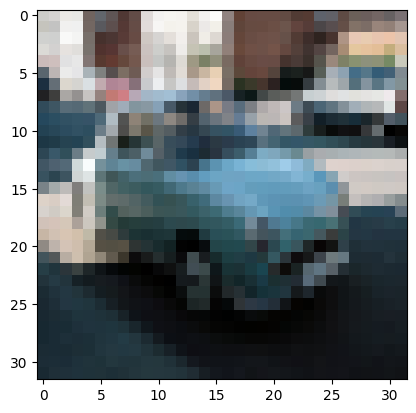

Ground truth label:  car
{'trained_LogisticRegression.pt': {'label': 'car', 'probability': '0.62'}, 'trained_LeNet.pt': {'label': 'car', 'probability': '0.91'}, 'trained_AlexNet.pt': {'label': 'car', 'probability': '0.89'}, 'tuned_AlexNet.pt': {'label': 'car', 'probability': '0.99'}}
Fine tuned model's prediction: {'label': 'car', 'probability': '0.99'}
Groud truth label: bird
{'trained_LogisticRegression.pt': {'label': 'car', 'probability': '0.82'}, 'trained_LeNet.pt': {'label': 'car', 'probability': '0.24'}, 'trained_AlexNet.pt': {'label': 'frog', 'probability': '0.52'}, 'tuned_AlexNet.pt': {'label': 'frog', 'probability': '0.43'}}
Fine tuned model's prediction: {'label': 'frog', 'probability': '0.43'}
All tests passed!


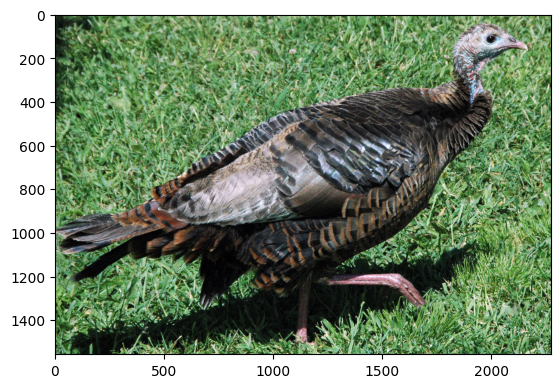

In [41]:
def test_local_deployment():
    # cifar-10 image
    cifar_img, label = full_valset[3]
    show_cifar_image(cifar_img)
    print("Ground truth label: ", classes[label])
    input_json = json.dumps({
        "image" : cifar_img.unsqueeze(0).numpy().tolist()
    })
    content = local_service.run(bytes(input_json, encoding = "utf-8"))
    print(content)
    assert content['trained_AlexNet.pt'] == {'label': 'car', 'probability': '0.89'}, content['trained_AlexNet.pt']
    assert content['trained_LeNet.pt'] == {'label': 'car', 'probability': '0.91'}, content['trained_LeNet.pt']
    assert content['trained_LogisticRegression.pt'] == {'label': 'car', 'probability': '0.62'}, content['trained_LogisticRegression.pt']
    print("Fine tuned model's prediction:", [pred for name, pred in content.items() if 'tuned' in name][0])

    # external image
    external_img = Image.open('test_img.jpg')
    plt.imshow(external_img)
    print("Groud truth label: bird")
    external_img_formatted = preprocess(external_img)
    input_json = json.dumps({
        "image" : external_img_formatted.tolist()
    })
    content = local_service.run(bytes(input_json, encoding = "utf-8"))
    print(content)
    assert content['trained_AlexNet.pt'] == {'label': 'frog', 'probability': '0.52'}, content['trained_AlexNet.pt']
    assert content['trained_LeNet.pt'] == {'label': 'car', 'probability': '0.24'}, content['trained_LeNet.pt']
    assert content['trained_LogisticRegression.pt'] == {'label': 'car', 'probability': '0.82'}, content['trained_LogisticRegression.pt']
    print("Fine tuned model's prediction:", [pred for name, pred in content.items() if 'tuned' in name][0])
    
    print("All tests passed!")

test_local_deployment()

**Step 6: Deploy to ACI container**

Now that your local service has worked properly, the last step is to deploy it to a pulic endpoint. Follow the steps in the primer to create an `AciWebService` and a new `Model.deploy` object, then call `wait_for_deployment` on it. This code should take about 20 minutes to run. If it takes longer, you should consult the "Monitoring public deployment" section in the primer to diagnose the issues.

In [46]:
## replace the None values with your code
aci_deployment_config = AciWebservice.deploy_configuration(
    cpu_cores=1, memory_gb=1, description='Public endpoint for PyTorch models',
    tags={'data' : 'CIFAR10', 'method' : 'pytorch models', 'framework' : 'pytorch'},
)
aci_service = Model.deploy(
    ws, "aci-service",
    [register_pytorch_model], inference_config, 
    aci_deployment_config
)
aci_service.wait_for_deployment(True)
print(aci_service.state)

/tmp/ipykernel_4838/1298385725.py:6: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  aci_service = Model.deploy(


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2023-11-08 22:03:28+00:00 Creating Container Registry if not exists.
2023-11-08 22:03:28+00:00 Registering the environment.
2023-11-08 22:03:29+00:00 Use the existing image.
2023-11-08 22:03:29+00:00 Generating deployment configuration.
2023-11-08 22:03:31+00:00 Submitting deployment to compute..
2023-11-08 22:03:48+00:00 Checking the status of deployment aci-service..
2023-11-08 22:06:39+00:00 Checking the status of inference endpoint aci-service.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


When the deployment succeeds, you will see the output as

```
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
```

If this cell runs for more than 30 minutes, something is wrong with `score.py` so you should:

1. Stop the code execution
1. Revise the `score.py` script. You can look at the deployment logs by running `print(aci_service.get_logs())` to see where the issue is.
1. After fixing the issue, delete the current service by running `aci_service.delete()`.
1. Rerun the last two cells to initialize and deploy a new service.

Unlike in the local deployment setting, it is not possible to update a publicly deployed service. Make sure to check your code carefully before deploying, so that you don't need to delete and redeploy too many times.

After the deployment finishes successfully, you can get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service. The following code cell will also write the endpoint to a text file, which will be collected by the `submitter` executable when you make a submission to Sail().

In [47]:
print(aci_service.scoring_uri)
with open('scoring_uri.txt', 'w') as f:
    f.write(aci_service.scoring_uri)
    print('Save scoring uri successfully!')

http://65a53964-e994-4996-a285-36daf4e5667f.eastus.azurecontainer.io/score
Save scoring uri successfully!


**Step 7: Test the public web service**

Finally, let's test this public endpoint with the same test cases we used earlier.

In [48]:
def ping_endpoint(flattened_img, uri = None):
    if uri is None:
        uri = open("scoring_uri.txt", "r").read()
    input_json = json.dumps({
        "image" : flattened_img
    })
    headers = {'Content-Type' : 'application/json'}
    response = requests.post(uri, bytes(input_json, encoding = "utf-8"), headers = headers)
    return response.status_code, json.loads(response.content.decode('utf-8'))

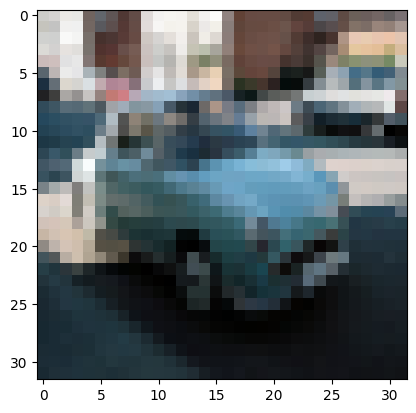

Ground truth label:  car
{'trained_LogisticRegression.pt': {'label': 'car', 'probability': '0.62'}, 'trained_LeNet.pt': {'label': 'car', 'probability': '0.91'}, 'trained_AlexNet.pt': {'label': 'car', 'probability': '0.89'}, 'tuned_AlexNet.pt': {'label': 'car', 'probability': '0.99'}}
Fine tuned model's prediction: {'label': 'car', 'probability': '0.99'}
Groud truth label: bird
{'trained_LogisticRegression.pt': {'label': 'car', 'probability': '0.82'}, 'trained_LeNet.pt': {'label': 'car', 'probability': '0.24'}, 'trained_AlexNet.pt': {'label': 'frog', 'probability': '0.52'}, 'tuned_AlexNet.pt': {'label': 'frog', 'probability': '0.43'}}
Fine tuned model's prediction: {'label': 'frog', 'probability': '0.43'}
All tests passed


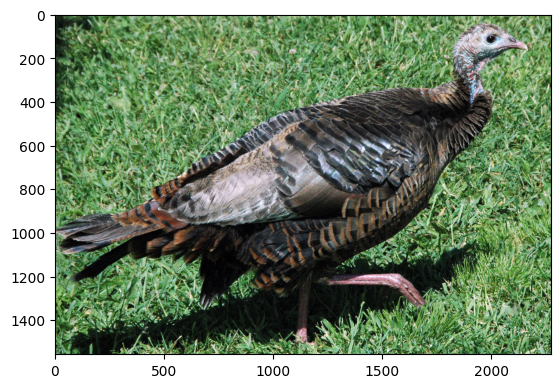

In [49]:
def test_aci_deployment():
    # cifar-10 image
    cifar_img, label = full_valset[3]
    show_cifar_image(cifar_img)
    print("Ground truth label: ", classes[label])
    status_code, content = ping_endpoint(cifar_img.unsqueeze(0).numpy().tolist())
    assert status_code == 200
    print(content)
    assert content['trained_AlexNet.pt'] == {'label': 'car', 'probability': '0.89'}, content['trained_AlexNet.pt']
    assert content['trained_LeNet.pt'] == {'label': 'car', 'probability': '0.91'}, content['trained_LeNet.pt'] 
    assert content['trained_LogisticRegression.pt'] == {'label': 'car', 'probability': '0.62'}, content['trained_LogisticRegression.pt']
    print("Fine tuned model's prediction:", [pred for name, pred in content.items() if 'tuned' in name][0])

    # external image
    external_img = Image.open('test_img.jpg')
    plt.imshow(external_img)
    print("Groud truth label: bird")
    external_img_formatted = preprocess(external_img)
    status_code, content = ping_endpoint(external_img_formatted.tolist())
    print(content)
    assert content['trained_AlexNet.pt'] == {'label': 'frog', 'probability': '0.52'}, content['trained_AlexNet.pt'] 
    assert content['trained_LeNet.pt'] == {'label': 'car', 'probability': '0.24'}, content['trained_LeNet.pt']
    assert content['trained_LogisticRegression.pt'] == {'label': 'car', 'probability': '0.82'}, content['trained_LogisticRegression.pt']
    print("Fine tuned model's prediction:", [pred for name, pred in content.items() if 'tuned' in name][0])
    
    print("All tests passed")

test_aci_deployment()

**Cleaning up cloud resources**

You have completed all the questions in this project! One last step you need to do is to make sure you clean up your resources properly, so that no unexpected charge is incurred.

Use the left navigation bar in the Azure Machine Learning Studio to manage your computes and endpoints. If you don't anticipate any further usage of Azure GPU for this project, you should go back to the [Azure homepage](https://portal.azure.com/) and delete the entire resource group, as the resource group itself also incurs charges over time, even without any computes or endpoints.

![endpoints](http://clouddatascience.blob.core.windows.net/m20-foundation-data-science/p5-model-deployment-comparison/managing_endpoints.png)